In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = "#ffffff"

In [2]:
data = MNIST(root='data/', download=True, transform=ToTensor())

image.shape:  torch.Size([1, 28, 28])
Label:  0


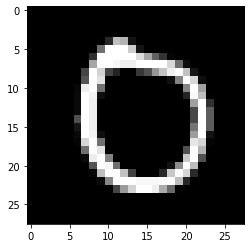

In [3]:
image,label = data[-44844]
print('image.shape: ', image.shape)
plt.imshow(image.reshape(28,28), cmap='gray')
print("Label: ", label)

In [4]:
val_size = 10000
train_size = len(data) - val_size

train_ds, val_ds = random_split(data, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

images.shape:  torch.Size([128, 1, 28, 28])
labels.shape:  torch.Size([128])
inputs.shape:  torch.Size([128, 784])


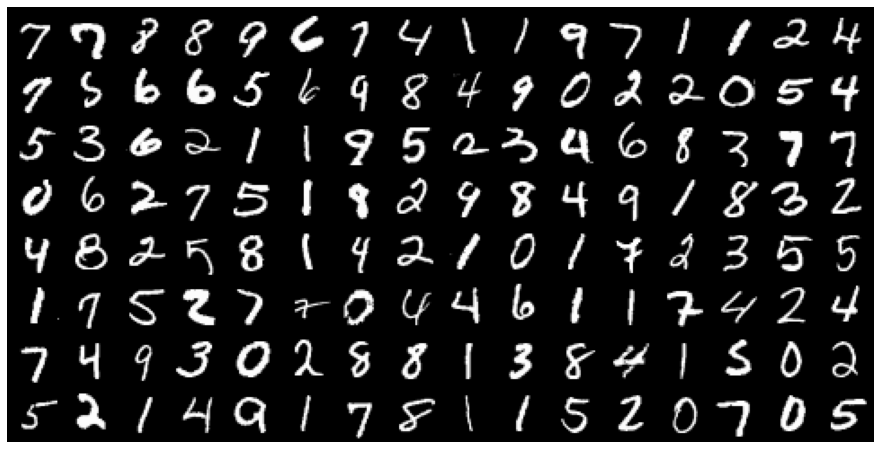

In [7]:
for images, label in train_loader:
    print('images.shape: ', images.shape)
    print('labels.shape: ', label.shape)
    print('inputs.shape: ', images.reshape(-1,784).shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [8]:
input_size = images.reshape(-1,784).shape[-1]
hidden_size = 32
num_classes = 10

print(input_size)
print(hidden_size)
print(num_classes)

print("\n\n\nIn totality: \n784 Columns going through computation and giving 32 columns, \nand those 32 columns going through another computation and giving 10 columns")

784
32
10



In totality: 
784 Columns going through computation and giving 32 columns, 
and those 32 columns going through another computation and giving 10 columns


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [10]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
 
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [11]:
model = MnistModel(in_size=input_size, hidden_size=hidden_size, out_size=num_classes)

In [12]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [13]:
torch.cuda.is_available()

True

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [19]:
def evaluate(mode, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.05898437649011612, 'val_loss': 2.31862735748291}]

In [22]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2442, val_acc: 0.9278
Epoch [1], val_loss: 0.2249, val_acc: 0.9321
Epoch [2], val_loss: 0.1609, val_acc: 0.9518
Epoch [3], val_loss: 0.1383, val_acc: 0.9608
Epoch [4], val_loss: 0.1419, val_acc: 0.9577


In [23]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1190, val_acc: 0.9656
Epoch [1], val_loss: 0.1194, val_acc: 0.9657
Epoch [2], val_loss: 0.1186, val_acc: 0.9655
Epoch [3], val_loss: 0.1170, val_acc: 0.9657
Epoch [4], val_loss: 0.1180, val_acc: 0.9652


In [24]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1142, val_acc: 0.9675
Epoch [1], val_loss: 0.1140, val_acc: 0.9664
Epoch [2], val_loss: 0.1148, val_acc: 0.9665
Epoch [3], val_loss: 0.1143, val_acc: 0.9664
Epoch [4], val_loss: 0.1133, val_acc: 0.9665


Text(0.5, 1.0, 'Loss vs. No. of epochs')

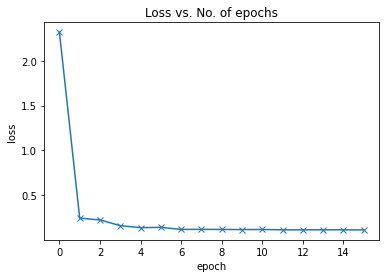

In [29]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

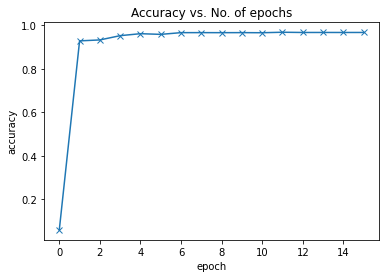

In [30]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [36]:
test_dataset = MNIST(root='data/',train=False,transform=ToTensor())
len(test_dataset)

10000

In [32]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label:  7 , Predicted:  7


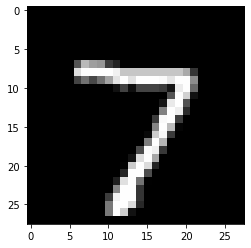

In [34]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ', Predicted: ', predict_image(img, model))

Label:  9 , Predicted:  9


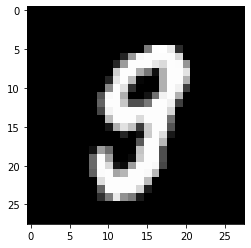

In [35]:
img, label = test_dataset[448]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ', Predicted: ', predict_image(img, model))

In [37]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.971972644329071, 'val_loss': 0.09476354718208313}

In [38]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')